# Setup

## Imports

In [3]:
using Pkg
Pkg.add("QuantumToolbox")

   Resolving package versions...
   Installed IncompleteLU ─── v0.2.1
   Installed QuantumToolbox ─ v0.12.1
    Updating `/local/gr400/Git Repositories/SuperconductingCavities/Project.toml`
⌅ [6c2fb7c5] + QuantumToolbox v0.12.1
  [2f01184e] ~ SparseArrays v1.10.0 ⇒ 
    Updating `/local/gr400/Git Repositories/SuperconductingCavities/Manifest.toml`
  [40713840] + IncompleteLU v0.2.1
⌅ [6c2fb7c5] + QuantumToolbox v0.12.1
  [b27032c2] ↓ LibCURL v0.6.4 ⇒ v0.6.3
  [44cfe95a] ↓ Pkg v1.10.0 ⇒ v1.9.2
  [2f01184e] ~ SparseArrays v1.10.0 ⇒ 
  [10745b16] ↓ Statistics v1.10.0 ⇒ v1.9.0
  [e66e0078] ↓ CompilerSupportLibraries_jll v1.1.1+0 ⇒ v1.0.5+0
  [781609d7] ↓ GMP_jll v6.2.1+6 ⇒ v6.2.1+2
  [deac9b47] ↓ LibCURL_jll v8.4.0+0 ⇒ v7.84.0+0
  [e37daf67] - LibGit2_jll v1.6.4+0
  [29816b5a] ↓ LibSSH2_jll v1.11.0+1 ⇒ v1.10.2+0
  [c8ffd9c3] ↓ MbedTLS_jll v2.28.2+1 ⇒ v2.28.2+0
  [14a3606d] ↓ MozillaCACerts_jll v2023.1.10 ⇒ v2022.10.11
  [4536629a] ↓ OpenBLAS_jll v0.3.23+4 ⇒ v0.3.21+4
  [05823500] ↓ OpenLib

In [1]:
import QuantumOptics as qo
using Logging

using LinearAlgebra
using SparseArrays


import CairoMakie as cm

using ProtoStructs

import QuantumOptics.⊗
import QuantumOptics.*

import OrdinaryDiffEq as ODE

import CSV
using JSON
import Tables

using YAXArrays
using DimensionalData

using MiniLoggers
using Dates
using Revise



In [2]:
import SuperconductingCavities as SC

[ Info: Precompiling SuperconductingCavities [ee3d56fb-bca2-435b-b019-382031bd701c]


## Extra Stuff

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(52) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [4]:
function tostr(obj)
    io = IOBuffer()
    show(io, "text/plain", obj)
    String(take!(io))
end

tostr (generic function with 1 method)

# Doing Stuff

In [5]:
Mode3 = SC.Transmon_Resonators_Loader("ModelSaves/Mode_3/Mode_3.json");

In [6]:
Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]

Dict{String, Any} with 6 entries:
  "pulse_time"    => 177.8
  "Envelope Args" => Dict{String, Any}("pulse_time"=>177.8, "ramp_time"=>10)
  "epsilon"       => 0.88
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "freq_d"        => -2.87015

In [7]:
ε = 0.78#Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["epsilon"];
freq_d = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"];
println(freq_d)

stark_shifts = collect(LinRange(0.02, 0.08, 21));


-2.870147109080264


## Floquet and Calibrating Pulses

[2024-09-12 13:48:59] Info: Beginning Floquet Sweep
[2024-09-12 13:49:24] Info: Done With Floquet Sweep
[2024-09-12 13:49:25] Info: Tracking State (0, 1)
[2024-09-12 13:49:25] Info: Tracking State (2, 0)
[2024-09-12 13:49:26] Info: Fit Stuff: 3-element Vector{Float64}:	 0.042214294051343304	 0.0025084691480055598	 2.1416665015605254


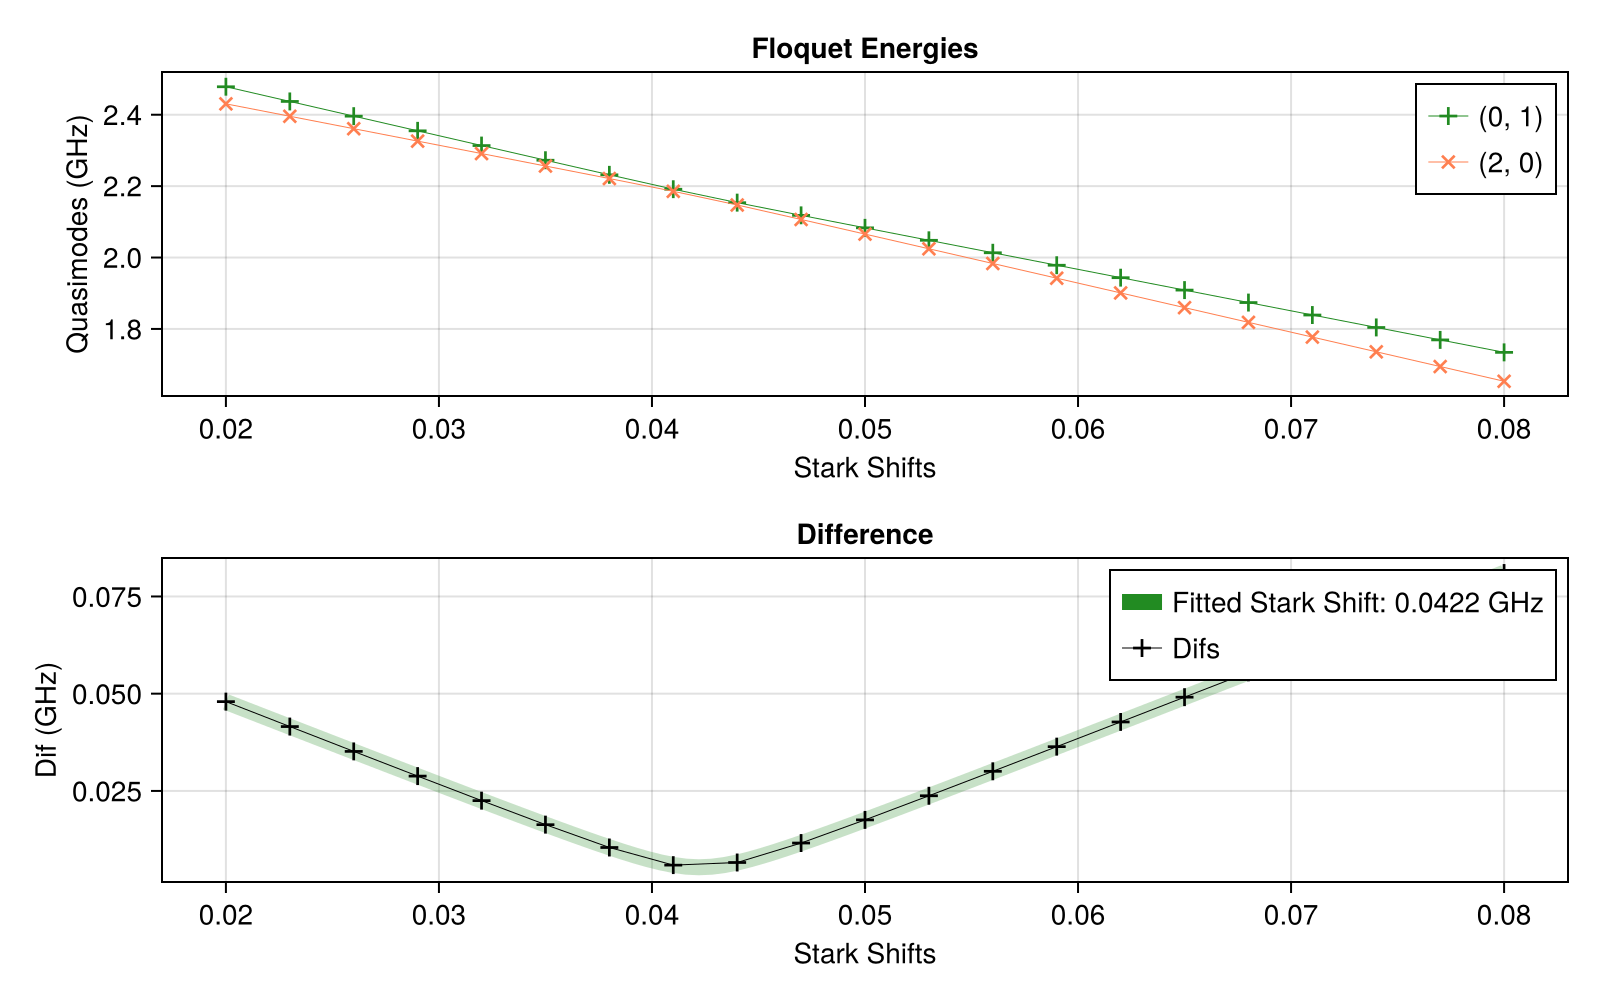

2-element Vector{Float64}:
   0.042214294051343304
 186.1398639909889

In [8]:
stark_shift_res = SC.FindStarkShift(Mode3, Mode3.n̂ₜ, (2,0), (0,1), ε, stark_shifts; make_plot = true)

In [45]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]
stark_shift = stark_shift_res[1]
t0 = stark_shift_res[2]
pulse_time = 198.33
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("pulse_time" => pulse_time, "ramp_time"=>10)

pulse_args = Dict{Any, Any}("pulse_time" => pulse_time, "shift" => stark_shift, "freq_d" => freq_d, "Envelope"=>envelope, "Envelope Args"=> envelope_args, "epsilon"=> ε)

solver_kwargs = Dict{Any, Any}("reltol" => 1e-4, "abstol"=>1e-4, "tol"=>1e-3, "alg" => ODE.Vern9())
res = SC.RunSingleOperator(Mode3, ψ1, pulse_args, to_return = "Overlaps", save_step = false, solver_kwargs = solver_kwargs);

[2024-09-12 11:31:23] Info: Running Time Evolution
[2024-09-12 11:31:47] Info: Time Evolution Complete
[2024-09-12 11:31:47] Info: Getting Overlaps
[2024-09-12 11:32:18] Info: Done with DEFAULT


In [103]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]
stark_shift = stark_shift_res[1]
t0 = stark_shift_res[2]
t_range = [t0, t0+20]
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("pulse_time" => 0.0, "ramp_time"=>10)
opt_pulse = SC.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args)

[2024-09-11 17:33:40] Info: On Level 1
[2024-09-11 17:33:40] Info: On Step 1: t = 186.1398639909889
[2024-09-11 17:33:40] Info: Running Time Evolution
[2024-09-11 17:34:02] Info: Time Evolution Complete
[2024-09-11 17:34:02] Info: Done with Level_1_step_1
[2024-09-11 17:34:02] Info: On Step 2: t = 191.1398639909889
[2024-09-11 17:34:02] Info: Running Time Evolution
[2024-09-11 17:34:25] Info: Time Evolution Complete
[2024-09-11 17:34:25] Info: Done with Level_1_step_2
[2024-09-11 17:34:25] Info: On Step 3: t = 196.1398639909889
[2024-09-11 17:34:25] Info: Running Time Evolution
[2024-09-11 17:34:49] Info: Time Evolution Complete
[2024-09-11 17:34:49] Info: Done with Level_1_step_3
[2024-09-11 17:34:49] Info: On Step 4: t = 201.1398639909889
[2024-09-11 17:34:49] Info: Running Time Evolution
[2024-09-11 17:35:04] Info: Time Evolution Complete
[2024-09-11 17:35:04] Info: Done with Level_1_step_4
[2024-09-11 17:35:04] Info: On Step 5: t = 206.1398639909889
[2024-09-11 17:35:04] Info: Runn

Dict{Any, Any} with 6 entries:
  "pulse_time"    => 197.702
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>197.702, "ramp_time"=>10)
  "epsilon"       => 0.78
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0422143
  "freq_d"        => -2.87015

## Floquet Sweep For Pulse

In [9]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]
stark_shift = 0.0422143;
ε = 0.78;
T = abs(1/(stark_shift+freq_d))
t0 = stark_shift_res[2]
pulse_time = 197.702
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}(:pulse_time => pulse_time, :ramp_time=>10)

println(ε)
println(stark_shift)
times = collect(0:5*T:pulse_time)

params_list = []
for t in times
    ε_temp = ε*SC.Sine_Squared_Ramp_Envelope(t; envelope_args...)
    params = Dict{Any, Any}("ν" => freq_d+stark_shift, "ε"=>ε_temp)
    push!(params_list, params)
end


0.78
0.0422143


In [10]:
envelope_args = Dict{Any, Any}("pulse_time" => pulse_time, "ramp_time"=>10)

pulse_args = Dict{Any, Any}("pulse_time" => pulse_time, "shift" => stark_shift, "freq_d" => freq_d, "Envelope"=>envelope, "Envelope Args"=> envelope_args, "epsilon"=> ε)

solver_kwargs = Dict{Any, Any}("reltol" => 1e-4, "abstol"=>1e-4, "tol"=>1e-3, "alg" => ODE.Vern9())
run_res = SC.RunSingleOperator(Mode3, ψ1, pulse_args, to_return = "All WFs", save_step = false, solver_kwargs = solver_kwargs, tspan = times);

[2024-09-12 13:49:49] Info: Running Time Evolution
[2024-09-12 13:50:09] Info: Time Evolution Complete
[2024-09-12 13:50:09] Info: Done with DEFAULT


In [11]:
floq_sweep_res = SC.Floquet_0_Sweep(Mode3, Mode3.n̂ₜ, params_list)

[2024-09-12 13:50:09] Info: Beginning Floquet Sweep


[2024-09-12 13:51:53] Info: Done With Floquet Sweep


Dict{Any, Any} with 2 entries:
  "F_Modes"    => Any[Ket{CompositeBasis{Vector{Int64}, Tuple{NLevelBasis{Int64…
  "F_Energies" => Any[[-8.83351, -8.80826, 8.69493, -8.57975, -8.4845, 8.38278,…

In [12]:
states_to_track = Dict{Any, Any}()
states_to_track["f0"] = Mode3.dressed_states[(2,0)]
states_to_track["g1"] = Mode3.dressed_states[(0,1)]
tracking_res = SC.State_Tracker(floq_sweep_res["F_Modes"], states_to_track, other_sorts = Dict{Any, Any}("F_Energies"=>floq_sweep_res["F_Energies"]));

[2024-09-12 13:51:54] Info: Tracking State f0
[2024-09-12 13:51:54] Info: Tracking State g1


In [13]:
#tracking_res[State = At("f0")]

In [20]:
y_f0_floq = []
y_g1_floq = []

for i in 1:length(times)
    push!(y_f0_floq, abs(run_res[2][i]'*tracking_res[State = At("f0")][i]["ψ"])^2)
    push!(y_g1_floq, abs(run_res[2][i]'*tracking_res[State = At("g1")][i]["ψ"])^2)
end

y_f0_floq_phase = []
y_g1_floq_phase = []

for i in 1:length(times)
    push!(y_f0_floq_phase, angle(run_res[2][i]'*tracking_res[State = At("f0")][i]["ψ"]))
    push!(y_g1_floq_phase, angle(run_res[2][i]'*tracking_res[State = At("g1")][i]["ψ"]))
end



In [23]:
println("Initial Phase Difference")
println(y_f0_floq_phase[1]-y_g1_floq_phase[1])

println("Final Phase Difference")
println(y_f0_floq_phase[end]-y_g1_floq_phase[end])


Initial Phase Difference-1.3356144910442644
Final Phase Difference2.83305603856173


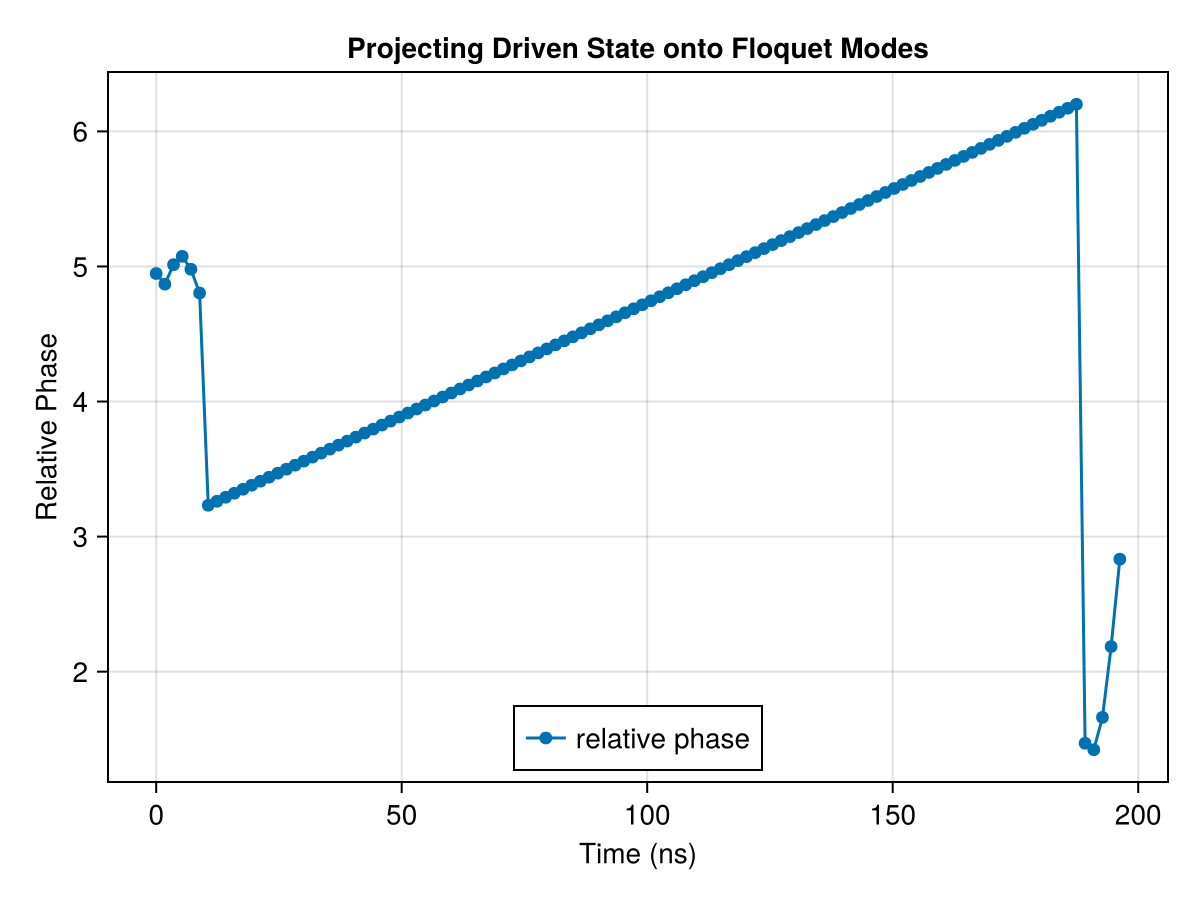

In [27]:
f = cm.Figure()
ax = cm.Axis(f[1,1], title = "Relative Phase", xlabel = "Time (ns)",  ylabel = "Relative Phase")

#cm.scatterlines!(ax, times, y_f0_floq_phase, label = "f0")
#cm.scatterlines!(ax, times, y_g1_floq_phase, label = "g1")
y =  y_f0_floq_phase-y_g1_floq_phase
for i in 1:length(y)
    if y[i]<0
        y[i] += 2 * pi
    end
end
cm.scatterlines!(ax, times, y, label = "relative phase")

cm.axislegend(position = :cb)

f

## Making Plots

In [29]:
dat = open_dataset("Data/Run_Loss_true_2024-09-11T19:09:13.261.nc")

YAXArray Dataset
Shared Axes: 
(↓ State Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered)
Variables: 
Step_1
  (↓ Step_1_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_8
  (↓ Step_8_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_5
  (↓ Step_5_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_9
  (↓ Step_9_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_15
  (↓ Step_15_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_17
  (↓ Step_17_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_11
  (↓ Step_11_Steps Sampled{Int64} 0:1:500 ForwardOrdered Regular Points)
Step_13
  (↓ Step_13_Steps Sampled{Int64} 0:1:358 ForwardOrdered Regular Points)
Step_2
  (↓ Step_2_Steps Sampled{Int64} 0:1:501 ForwardOrdered Regular Points)
Step_10
  (↓ Step_10_Steps Sampled{Int64} 0:1:485 ForwardOrdered Regular Points)
Step_18
  (↓ Step_18_Steps Sampled{Int64} 0:1:4857 ForwardOrdered Regular Points)

[2024-09-12 11:12:15] Info: Organizing Data
[2024-09-12 11:12:15] Info: Making Plot


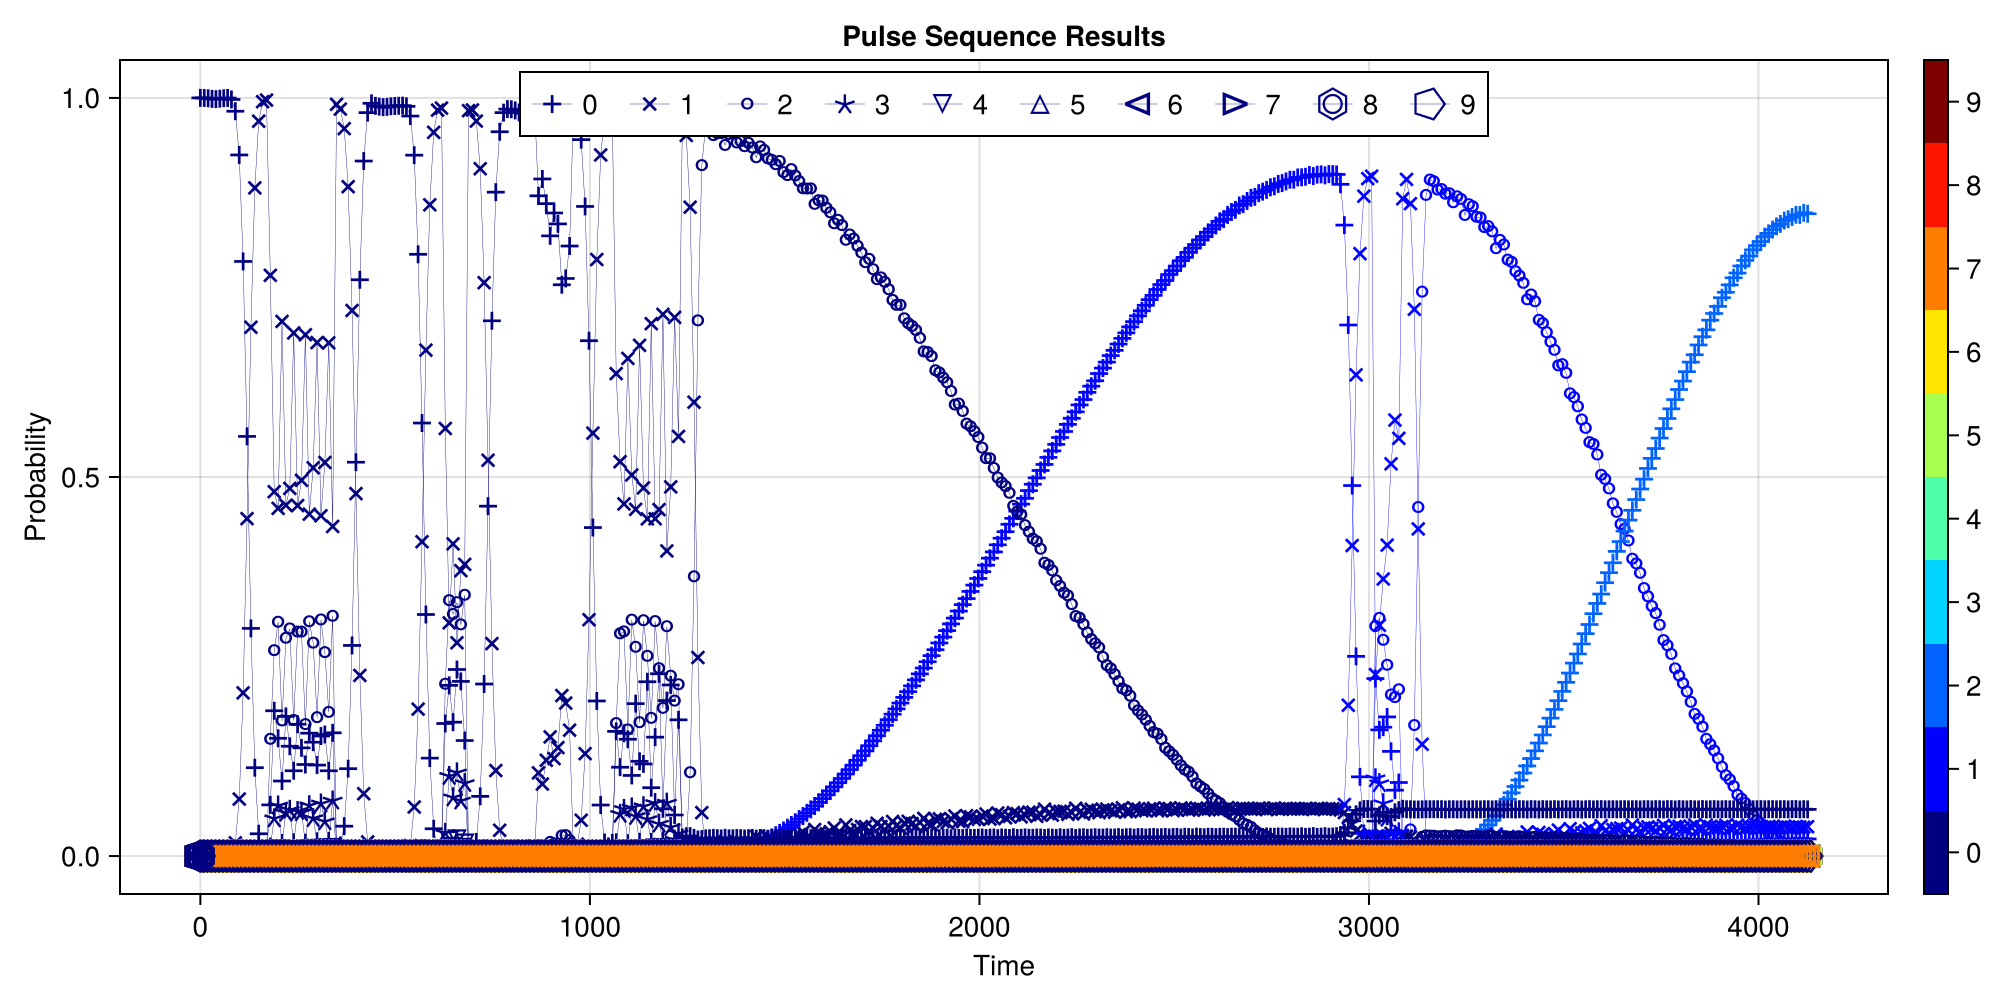

In [30]:
SC.ProbabilityPlotSingleModeEvolution(Mode3, dat, plot_every = 50)

In [31]:
dat.cubes[:Step_18][State = At(string((0,2)))].data[end]

0.8472132361069609